## imports and data 

In [1]:
act = 365

import pandas as pd
import numpy as np
import scipy.optimize as opt
from numba import jit, njit, set_num_threads
set_num_threads(3)


import pickle
with open("Data/gaussian_cdf.pkl", "rb") as f:
    pkl = pickle.load(f)

Rates_monthly_data = pd.read_csv("Data/rates_monthly.csv", index_col=0, parse_dates=True)


### GLOBAL VARIABLES ###
MTG_MAT = 30
MONTHLY = True
factor = 1
if MONTHLY:
    factor *= 12

TRIANG = np.tri(MTG_MAT*factor+1, MTG_MAT*factor+1).T
ALL_CPNS = np.arange(2.5, 7.0, 0.5)
ALL_CPNS_TBAS = np.arange(1.5, 8.0, 0.5)


OAS_DATA = pd.read_csv("Data/OAS_vs_TREAS.csv", index_col=0)
OAS_DATA.index = pd.to_datetime(OAS_DATA.index, format="%Y-%m-%d")
OAS_DATA = OAS_DATA.iloc[:, :9]
OAS_DATA.columns = ALL_CPNS
OAS_DATA.dropna(how='all', inplace=True)

TBAS_PRICES = pd.read_csv("Data/GENERIC_TBAS.csv", index_col=0).dropna(how="all")
TBAS_PRICES.index = pd.to_datetime(TBAS_PRICES.index, format="%Y-%m-%d")
TBAS_PRICES.columns = ALL_CPNS_TBAS
TBAS_PRICES.dropna(how='all', inplace=True)

IMPLIED_VOL_DATA = pd.read_csv("Data/implied_vol.csv", index_col=0).dropna(how="all")
IMPLIED_VOL_DATA.index = pd.to_datetime(IMPLIED_VOL_DATA.index, format="%Y-%m-%d")
IMPLIED_VOL_DATA = IMPLIED_VOL_DATA['3M10Y'].dropna()
IMPLIED_VOL_DATA = IMPLIED_VOL_DATA.apply(lambda x: float(x.replace(',', '.'))).sort_index()
IMPLIED_VOL_DATA.dropna(how='all', inplace=True)
implied_usd = IMPLIED_VOL_DATA


MTG = pd.read_csv('Data/MTG_RATE.csv', index_col=0)
MTG.index = pd.to_datetime(MTG.index, format="%m/%d/%y")
MTG = MTG[['Mortgage Rate']]
MTG.dropna(how='all', inplace=True)
for i, val in enumerate(ALL_CPNS):
    MTG[val] = val - MTG["Mortgage Rate"]

LOAN_AGE = pd.read_csv('Data/loan_age.csv', index_col=0)
LOAN_AGE.index = pd.to_datetime(LOAN_AGE.index, format="%m/%d/%y")
LOAN_AGE = LOAN_AGE[[str(c) for c in ALL_CPNS]]
LOAN_AGE.columns = ALL_CPNS
LOAN_AGE.dropna(how='all', inplace=True)

dates = [ d for d in Rates_monthly_data.index if 
        (
            d in IMPLIED_VOL_DATA.index and 
            d in TBAS_PRICES.index and 
            d in MTG.index and 
            d in LOAN_AGE.index
        )]

Rates_monthly_data= Rates_monthly_data         .loc[dates]
IMPLIED_VOL_DATA  = IMPLIED_VOL_DATA  .loc[dates]
TBAS_PRICES       = TBAS_PRICES       .loc[dates] 
MTG               = MTG               .loc[dates] 
LOAN_AGE          = LOAN_AGE          .loc[dates]


## functions

In [15]:
# fixeds params
LOW_CPR = 0.1
HIGH_CPR = 0.4

In [16]:
# Optimized function
@njit()
def retrieve_erf(x, my_pickle):
    """Retrieve the Gaussian CDF of x efficiently."""
    x_values, cdf_values = my_pickle
    closest_x_idx = np.argmin(np.abs(x_values - x))
    return cdf_values[closest_x_idx]

@njit()
def PRICE_MBS(SOFR_DATA, COUPON, OAS, 
              MTG_MATURITY=30,
              VOL=100,
              floor_quantity=0.5, most_expensive_quantity=0.5,
              LOW_CPR=LOW_CPR, HIGH_CPR=HIGH_CPR, 
              my_pickle=pkl):
    """Compute the price of an MBS with optimized performance."""
    factor = 12
    LENGTH = MTG_MATURITY * factor + 1
    LENGTH_IDX = np.arange(LENGTH)

    COUPON = COUPON/100
    CPN = COUPON/ factor
    
    VOL = VOL*1e-4
    N0 = 100

    # Compute annuity and prepayment schedules
    annuity = N0 * (1 - (1 + CPN) ** -((MTG_MATURITY * factor - LENGTH_IDX))) / (1 - (1 + CPN) ** (-MTG_MATURITY * factor))
    low_cpr = annuity * (1 - LOW_CPR) ** (LENGTH_IDX / factor)
    #high_cpr = low_cpr * (1 - HIGH_CPR) / (1 - LOW_CPR)
    high_cpr = annuity * (1 - HIGH_CPR)** (LENGTH_IDX / factor)

    # Compute cash flows
    cf_bond = np.zeros(LENGTH)
    cf_bond[1:] = (low_cpr[:-1]) * (1 + CPN) - low_cpr[1:]
    
    # Discount factors
    rates_oas = (SOFR_DATA + OAS/100)[:LENGTH] / 100
    ti_in_years = LENGTH_IDX * 30 / 365
    zero_coupon = np.exp(-rates_oas * ti_in_years)
    bond_price = np.sum(cf_bond * zero_coupon)

    # Option pricing calculations
    notional_diff = low_cpr - high_cpr
    weights = np.zeros(LENGTH)
    weights[1:] = zero_coupon[1:] * low_cpr[:-1]

    duration = np.cumsum(weights[::-1])[::-1]
    duration = np.roll(duration, -1)
    duration[:-1] = duration[:-1] / (zero_coupon * low_cpr * factor)[:-1]
    duration[-1] = 0

    fwd_rates = np.zeros(LENGTH)
    fwd_rates[1:] = (zero_coupon[:-1] / zero_coupon[1:] - 1) * factor
    weighted_fwd_rates = weights * fwd_rates

    swap_rate = np.cumsum(weighted_fwd_rates[::-1])[::-1]
    swap_rate = np.roll(swap_rate, -1)
    swap_rate[:-1] = swap_rate[:-1] / (duration * (zero_coupon * low_cpr * factor))[:-1]
    swap_rate[-1] = 0

    x_swaption = (COUPON - swap_rate)[1:-1] / (VOL * np.sqrt(LENGTH_IDX / factor))[1:-1]
    ERF_swpt = np.array([retrieve_erf(x, my_pickle) for x in x_swaption])
    density_swpt = (1 / np.sqrt(2 * np.pi)) * np.exp((-x_swaption**2) / 2)
    p_swaptions = (duration * VOL * np.sqrt(LENGTH_IDX / factor))[1:-1] * (x_swaption * ERF_swpt + density_swpt)
    p_swaptions = notional_diff[1:-1] * zero_coupon[1:-1] * p_swaptions
    ret_max_spt = np.nanmax(p_swaptions)

    x_cap = (COUPON - fwd_rates)[1:-1] / (VOL * np.sqrt(LENGTH_IDX / factor))[1:-1]
    ERF_cap = np.array([retrieve_erf(x, my_pickle) for x in x_cap])
    density_cap = (1 / np.sqrt(2 * np.pi)) * np.exp((-x_cap**2) / 2)
    p_cap = (zero_coupon * VOL * np.sqrt(LENGTH_IDX / factor))[1:-1] * (x_cap * ERF_cap + density_cap) * notional_diff[1:-1] / factor
    caplet_sum = np.nansum(p_cap)

    return bond_price - (most_expensive_quantity * ret_max_spt + floor_quantity * caplet_sum)

@njit()
def compute_OAS(
    market_price,
    SOFR_DATA, COUPON, 
    MTG_MATURITY=30,
    VOL=100,
    floor_quantity=0.5, most_expensive_quantity=0.5,
    LOW_CPR=LOW_CPR, HIGH_CPR=HIGH_CPR,
    my_pickle=pkl):
    """Compute the Option-Adjusted Spread (OAS) by finding the root of PRICE_MBS - market_price."""


    x = 0
    max_iter=100
    tol = 1e-5
    h = 1
    for _ in range(max_iter):               
        fx = PRICE_MBS(SOFR_DATA, COUPON, x, 
              MTG_MATURITY, VOL, floor_quantity, most_expensive_quantity,
              LOW_CPR, HIGH_CPR, my_pickle) - market_price
        
        f1x = PRICE_MBS(SOFR_DATA, COUPON, x+h, 
              MTG_MATURITY, VOL, floor_quantity, most_expensive_quantity,
              LOW_CPR, HIGH_CPR, my_pickle) - market_price             

        df_x = (f1x - fx) / h  # Numerical derivative approximation
        converged = abs(fx) < tol
        if converged:  # Stop if value is zero
            return x
        x -= fx / df_x  # Newton's update step
    
    return np.nan

In [17]:
@njit(parallel=True)
def compute_oas_accross_cpns(tba_price_t, rates_t, loan_age_t):
    n_cpn = len(ALL_CPNS)
    oas_t = np.zeros(n_cpn)
    for cpn_idx in range(n_cpn) :
        c = ALL_CPNS[cpn_idx]
        market_price = tba_price_t[cpn_idx]            
        MTG_MATURITY = 30 - round(loan_age_t[cpn_idx])
        oas_t[cpn_idx]  = compute_OAS(market_price , rates_t, c, 
                MTG_MATURITY=MTG_MATURITY)
    return oas_t 

In [19]:
Rates_monthly_data_array = Rates_monthly_data.to_numpy()
loan_age_array = LOAN_AGE[ALL_CPNS].to_numpy()
tba_price_array = TBAS_PRICES[ALL_CPNS].to_numpy()
n_dates = len(dates)
n_cpn = len(ALL_CPNS) 

oas_tab = np.zeros_like(tba_price_array)

start = 0
end = 10
for date_idx in range(start, end) :

    rates_t = Rates_monthly_data_array[date_idx]
    tba_price_t = tba_price_array[date_idx]
    loan_age_t = loan_age_array[date_idx]
    oas_tab[date_idx] = compute_oas_accross_cpns(tba_price_t, rates_t, loan_age_t)

## sanity checks

In [27]:
## sanity checks 

from tqdm import tqdm


date_idx = 0 
cpn_idx = 0

rates_t = Rates_monthly_data_array[date_idx]
c = ALL_CPNS[cpn_idx]
market_price = tba_price_array[date_idx, cpn_idx]            
MTG_MATURITY = 30 - round(loan_age_array[date_idx, cpn_idx])

l = np.zeros(10)
for i in tqdm(range(10)):
        oas  = compute_OAS(market_price+i/10 , rates_t, c, 
                MTG_MATURITY=MTG_MATURITY)   
        l[i] = oas

100%|██████████| 10/10 [00:01<00:00,  8.71it/s]


## compute oas and durations

In [ ]:
start = 0
end = 60
oas_tab = compute_OAS_across_dates(start, end)

In [6]:
OAS_computed = pd.DataFrame(index = dates, columns = ALL_CPNS)
OAS_computed.loc[dates[start: end]] = oas_tab[start: end, :]

In [9]:
from tqdm import tqdm


oas_tab = OAS_computed.to_numpy()

n_dates = len(dates)
n_cpn = len(ALL_CPNS) 

#@njit()
def compute_dur_across_dates(start=0, end=n_dates) : 

    dur_tab = np.zeros_like(tba_price_array)
    for date_idx in tqdm(range(start, end)) :

        rates_t = Rates_monthly_data_array[date_idx]
        for cpn_idx in range(n_cpn) :
            c = ALL_CPNS[cpn_idx]
            market_price = tba_price_array[date_idx, cpn_idx]            
            MTG_MATURITY = 30 - round(loan_age_array[date_idx, cpn_idx])
            oas = oas_tab[date_idx, cpn_idx]
            duration = -PRICE_MBS(rates_t, c, oas+1, 
                        MTG_MATURITY) + market_price
            duration = duration*100
            
            dur_tab[date_idx, cpn_idx] = duration

    return dur_tab

In [10]:
dur_tab = compute_dur_across_dates(start=0, end=n_dates)

100%|██████████| 2966/2966 [06:04<00:00,  8.15it/s]


In [11]:
start = 0
end = n_dates
DUR_computed = pd.DataFrame(index = dates, columns = ALL_CPNS)
DUR_computed.loc[dates[start: end]] = dur_tab[start: end, :]

<Axes: >

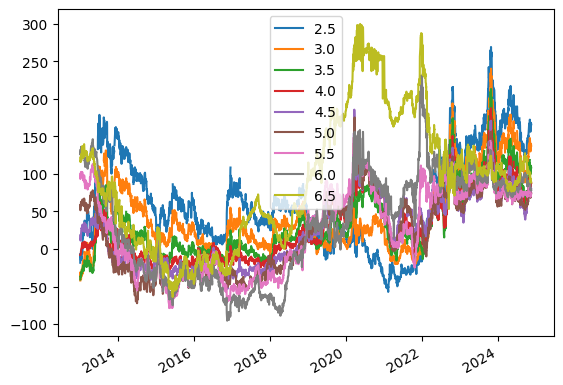

In [12]:
OAS_computed.plot()

<Axes: >

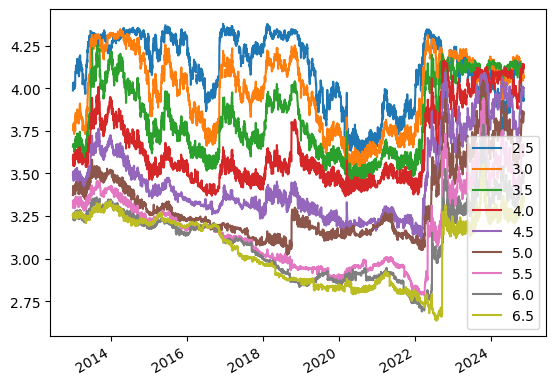

In [13]:
DUR_computed.plot()

In [15]:
sub_folder = f'hcn_model_samy_cpr_10_40'
import os
if not os.path.isdir(f'Data/{sub_folder}'):
    os.mkdir(f'Data/{sub_folder}')
OAS_computed.to_csv(f"Data/{sub_folder}/OAS.csv")

#### EXPORTING GREEKS ####
DUR_computed.to_csv(f"Data/{sub_folder}/Durations.csv")

<Axes: >

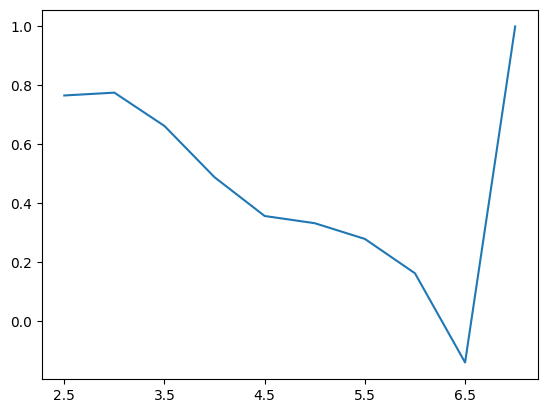

In [16]:
r5y = Rates_monthly_data['1500']
temp = OAS_computed.copy().astype(float)
temp['r5y'] = r5y
temp.corr()['r5y'].plot()